In [254]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.signal import periodogram, spectrogram, butter, lfilter
# from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

# Readings from Arduino

In [968]:
# df = pd.read_csv("../data/2020-08-25T06_26_17.629Z.csv", parse_dates=[0])
# df = pd.read_csv("../data/2020-08-25T06_11_15.569Z.csv", parse_dates=[0])
# graph_samplerate = 1
# rps = 2
# df = pd.read_csv("../data/2020-08-26T05_55_55.064Z.csv")
# df = pd.read_csv("../data/2020-08-26T10_48_47.786Z.csv")
df = pd.read_csv("../data/chest3.csv")
graph_samplerate = 5 # seaborn doesn't like many points
rps = 100 # records per second
df

,time,aX,aY,aZ,gX,gY,gZ
0,106194,0.925049,-0.294800,0.257080,-0.244141,-2.929688,-0.854492
1,106204,0.926758,-0.293579,0.255249,-0.366211,-3.173828,-0.793457
2,106214,0.927124,-0.296265,0.252197,-0.183105,-3.295898,-0.793457
3,106224,0.928223,-0.300903,0.247803,0.183105,-3.356934,-0.915527
4,106234,0.932739,-0.297363,0.244873,0.610352,-3.234863,-1.220703
...,...,...,...,...,...,...,...
5501,138178,0.910645,-0.282959,0.302490,0.366211,-2.807617,-0.915527
5502,138188,0.912354,-0.282837,0.300049,0.549316,-2.624512,-0.732422
5503,138198,0.912964,-0.284668,0.299316,0.488281,-2.563477,-0.671387
5504,138208,0.913086,-0.286621,0.299683,0.305176,-2.868652,-0.366211


Find vector pointing to the ground. There's a recording of standing still, before walking starts. The average vector can be used as the gravity reference, and subtracted from all the readings.

<AxesSubplot:xlabel='time', ylabel='aZ'>

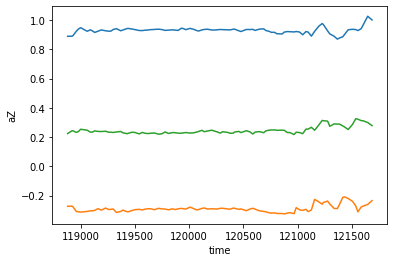

In [967]:
_df = df.iloc[22*rps:27*rps]
# _df = df.iloc[100:120]
# _df.loc[:,["aX"]] = sp.ndimage.median_filter(_df.loc[:,["aX"]], 5)
# _df.loc[:,["aY"]] = sp.ndimage.median_filter(_df.loc[:,["aY"]], 5)
# _df.loc[:,["aZ"]] = sp.ndimage.median_filter(_df.loc[:,["aZ"]], 5)
# _df = df.iloc[30:90]
_dfsample = _df.iloc[::graph_samplerate]
# _dfsample = _df.iloc[::graph_samplerate]
sns.lineplot(data=_dfsample, x="time", y="aX")
sns.lineplot(data=_dfsample, x="time", y="aY")
sns.lineplot(data=_dfsample, x="time", y="aZ")

In [939]:
ground_vector = _df.loc[:,["aX", "aY", "aZ"]].mean()

In [940]:
display("Ground vector",ground_vector.values,"magnitude",np.sqrt((ground_vector**2).sum()))

'Ground vector'

array([ 0.93015894, -0.28892285,  0.24652246])

'magnitude'

1.004711591583325

In [941]:
acceleration = (df.loc[:,["aX", "aY", "aZ"]] - ground_vector) * 9.8
# acceleration = df2.loc[:,["aX", "aY", "aZ"]] - ground_vector
acceleration["time"] = df.time

<AxesSubplot:xlabel='time', ylabel='aZ'>

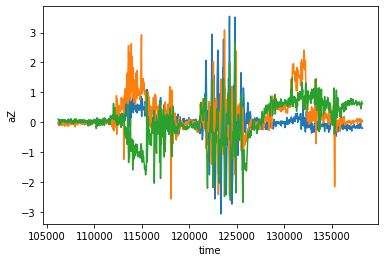

In [942]:
sns.lineplot(data=acceleration.iloc[::graph_samplerate], x="time", y="aX")
sns.lineplot(data=acceleration.iloc[::graph_samplerate], x="time", y="aY")
sns.lineplot(data=acceleration.iloc[::graph_samplerate], x="time", y="aZ")

Select only the range of readings that corresponds to a walk. We consider negative Z axis as the direction of a walk (when the device is mounted on a chest)

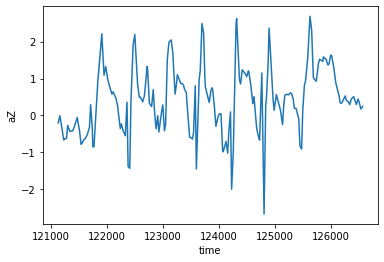

In [960]:
a, b = int(26 * rps), int(35.5 * rps)
# a, b = (120,190)
sample = acceleration.iloc[a:b]
# sample.aZ = -sample.aZ
# sample_mu = mu.reshape(-1,)[a:b]
# Median filtering removes noise, but the integration results are virtually the same
# size = 13
# sample.loc[:,["aX"]] = sp.ndimage.median_filter(sample.loc[:,["aX"]], size)
# sample.loc[:,["aY"]] = sp.ndimage.median_filter(sample.loc[:,["aY"]], size)
# sample.loc[:,["aZ"]] = sp.ndimage.median_filter(sample.loc[:,["aZ"]], size)
# velsample = sp.integrate.cumtrapz(y=-sample.aZ.values)
# velsample_mu = sp.integrate.cumtrapz(y=sample_mu)
_sample = sample.iloc[::graph_samplerate]
# sns.lineplot(data=_sample, x="time", y="aX")
# sns.lineplot(data=_sample, x="time", y="aY")
sns.lineplot(data=_sample, x="time", y=-sample.aZ)
# sns.lineplot(x=sample.time, y=sample_mu)
plt.show()
# sns.lineplot(x=sample.time[1:], y=velsample)
# sns.lineplot(x=sample.time[1:], y=velsample_mu)
# plt.show()
# sns.lineplot(data=sample, x="time", y="aY")
# sns.lineplot(data=sample, x="time", y="aZ")


In [944]:
time = (sample.time - sample.time.min()) / 1000
dtime = (sample.time.max() - sample.time.min()) / 1000 # Total duration of a walk in seconds
# Mean average speed. We assume the speed to be constant during the walk
vbar = 4.5 / dtime
# Estimate displacement with the constant speed. 
# In the real world scenario and for longer walks/runs, we would rely on GPS data instead  
x = [x * vbar for x in time.values]
# Integrate force with respect to displacement to get total work done
work = sp.integrate.trapz(y=-sample.aZ.values * 85, x=x)
(dtime, vbar, work / dtime, work)


(5.48, 0.8211678832116788, 29.57077308446188, 162.0478365028511)

# Readings from Android
See comments in the previous section for details on the analysis done

In [945]:
df2 = pd.read_csv("../data/chest-android.csv").drop("LinearAccelerometerSensor", axis=1).dropna().rename({
    "relative_time": "time",
    "AccX": "aX",
    "AccY": "aY",
    "AccZ": "aZ",
}, axis=1)
graph_samplerate2 = 1 # seaborn doesn't like many points
df2

,time,aX,aY,aZ
0,0,1.053449,7.077260,7.067683
1,84,0.871489,6.349423,6.828263
4,113,1.312023,4.912902,6.339846
8,180,-0.679953,5.219360,7.920019
18,311,0.430956,2.566584,11.109096
...,...,...,...,...
1420,22421,-0.421380,2.269703,8.427590
1424,22487,-0.641646,2.719813,9.979033
1429,22553,0.268151,2.997540,7.287950
1433,22625,-0.574608,2.422932,9.892841


In [946]:
df2.time.max() - df2.time.min()

22685

<AxesSubplot:xlabel='time', ylabel='aZ'>

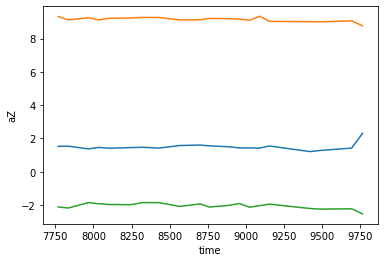

In [947]:
# _df = df2.iloc[22*rps:27*rps]
_df = df2.iloc[100:120]
# _df.loc[:,["aX"]] = sp.ndimage.median_filter(_df.loc[:,["aX"]], 5)
# _df.loc[:,["aY"]] = sp.ndimage.median_filter(_df.loc[:,["aY"]], 5)
# _df.loc[:,["aZ"]] = sp.ndimage.median_filter(_df.loc[:,["aZ"]], 5)
# _df = df.iloc[30:90]
_dfsample = _df.iloc[::graph_samplerate2]
# _dfsample = _df.iloc[::graph_samplerate]
sns.lineplot(data=_dfsample, x="time", y="aX")
sns.lineplot(data=_dfsample, x="time", y="aY")
sns.lineplot(data=_dfsample, x="time", y="aZ")

In [948]:
ground_vector = _df.loc[:,["aX", "aY", "aZ"]].mean()

In [949]:
display("Ground vector",ground_vector.values,"magnitude",np.sqrt((ground_vector**2).sum()))

'Ground vector'

array([ 1.49254534,  9.14393492, -2.05997115])

'magnitude'

9.491191627160624

In [950]:
acceleration2 = df2.loc[:,["aX", "aY", "aZ"]] - ground_vector
# acceleration = df2.loc[:,["aX", "aY", "aZ"]] - ground_vector
acceleration2["time"] = df2.time

<AxesSubplot:xlabel='time', ylabel='aZ'>

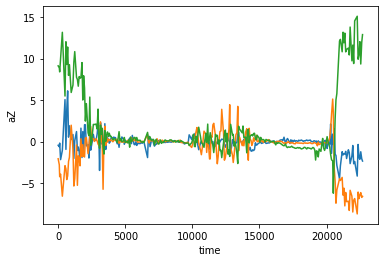

In [951]:
sns.lineplot(data=acceleration2, x="time", y="aX")
sns.lineplot(data=acceleration2, x="time", y="aY")
sns.lineplot(data=acceleration2, x="time", y="aZ")

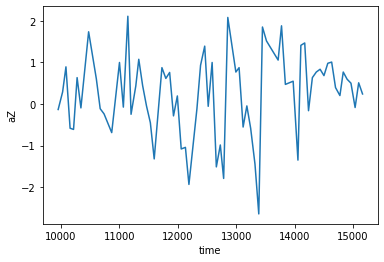

In [958]:
# a, b = int(26 * rps), int(35.5 * rps)
a, b = (120,190)
sample = acceleration2.iloc[a:b]
# sample_mu = mu.reshape(-1,)[a:b]
# Median filtering removes noise, but the integration results are virtually the same
# size = 13
# sample.loc[:,["aX"]] = sp.ndimage.median_filter(sample.loc[:,["aX"]], size)
# sample.loc[:,["aY"]] = sp.ndimage.median_filter(sample.loc[:,["aY"]], size)
# sample.loc[:,["aZ"]] = sp.ndimage.median_filter(sample.loc[:,["aZ"]], size)
# velsample = sp.integrate.cumtrapz(y=-sample.aZ.values)
# velsample_mu = sp.integrate.cumtrapz(y=sample_mu)
_sample = sample.iloc[::graph_samplerate2]
# sns.lineplot(data=_sample, x="time", y="aX")
# sns.lineplot(data=_sample, x="time", y="aY")
sns.lineplot(data=_sample, x="time", y=sample.aZ)
# sns.lineplot(x=sample.time, y=sample_mu)
plt.show()
# sns.lineplot(x=sample.time[1:], y=velsample)
# sns.lineplot(x=sample.time[1:], y=velsample_mu)
# plt.show()
# sns.lineplot(data=sample, x="time", y="aY")
# sns.lineplot(data=sample, x="time", y="aZ")


In [953]:
time = (sample.time - sample.time.min()) / 1000
dtime = (sample.time.max() - sample.time.min()) / 1000
vbar = 4.5 / dtime
x = [x * vbar for x in time.values]
work = sp.integrate.trapz(y=sample.aZ.values * 85, x=x)
(dtime, vbar, work / dtime, work)


(5.207, 0.8642212406376033, 19.814510206149293, 103.17415464341937)

# Misc
Gyroscope, spectrograms, filtering, etc. WIP

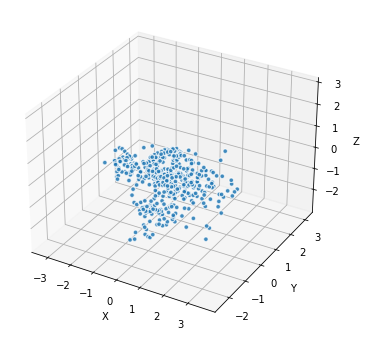

In [961]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sample.aX, sample.aY, sample.aZ, s=20, alpha=0.6, edgecolors='w')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [641]:
steps = len(-sample.aZ.values)
dtime = steps * 0.01
vbar = 4.5 / dtime
x_spacing = vbar * 0.01
x = np.arange(0,4.5,x_spacing)
work = sp.integrate.trapz(y=-sample.aZ.values * 9.8 * 85, x=x)
(vbar, work / dtime, work)

(0.6716417910447761, 17.620378419968866, 118.05653541379141)

In [ ]:
X = np.stack([sample.aX.values[1:], velsample]).T
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1).em(velsample)

In [ ]:
velsample_filtered = kf.smooth(velsample)[0].reshape(-1,)

In [ ]:
# sns.lineplot(x=sample.time[1:], y=velsample)
sns.lineplot(x=sample.time[1:], y=velsample_mu)
sns.lineplot(x=sample.time[1:], y=velsample_filtered)
plt.show()

<AxesSubplot:xlabel='time', ylabel='aZ'>

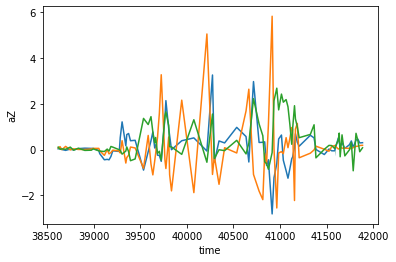

In [670]:
_a = acceleration.iloc[::graph_samplerate]
sns.lineplot(data=_a, x="time", y="aX")
sns.lineplot(data=_a, x="time", y="aY")
sns.lineplot(data=_a, x="time", y="aZ")

In [541]:
velocity = pd.DataFrame(sp.integrate.cumtrapz(y=acceleration.loc[:, ["aX", "aY", "aZ"]], x=acceleration.time, axis=0), columns=["vX", "vY", "vZ"])
velocity["time"] = acceleration.time
velocity["magnitude"] = (velocity.loc[:,["vX", "vY", "vZ"]]**2).sum(axis=1)

<AxesSubplot:xlabel='time', ylabel='vZ'>

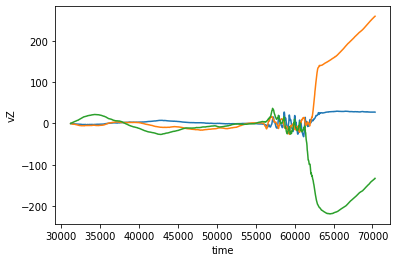

In [542]:
vsample = velocity.iloc[::graph_samplerate]
sns.lineplot(data=vsample, x="time", y="vX")
sns.lineplot(data=vsample, x="time", y="vY")
sns.lineplot(data=vsample, x="time", y="vZ")

<AxesSubplot:xlabel='time', ylabel='magnitude'>

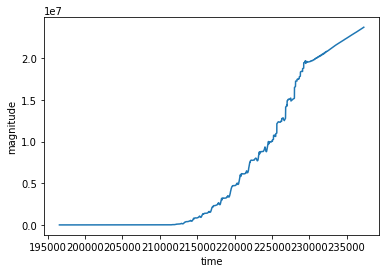

In [243]:
sns.lineplot(data=vsample, x="time", y="magnitude")

In [638]:
acceleration["magnitude"] = np.sqrt((acceleration.loc[:,["aX", "aY", "aZ"]]**2).sum(axis=1))

<AxesSubplot:xlabel='time', ylabel='magnitude'>

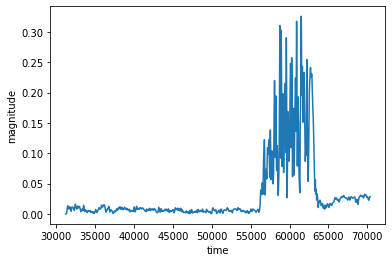

In [587]:
sns.lineplot(data=acceleration, x="time", y="magnitude")

In [546]:
def get_vertical(x, ground):
    return - np.dot(x, ground) / np.linalg.norm(ground)

vertical_acceleration = np.array([get_vertical(x, ground_vector) for x in acceleration.loc[:,["aX", "aY", "aZ"]].values])

In [547]:
vertical_acceleration

array([ 0.00032101,  0.00432037,  0.00530866, ..., -0.00293954,
        0.00389315,  0.01047221])

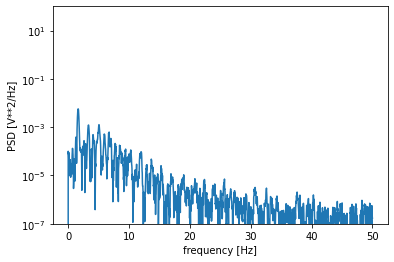

In [548]:
f, Pxx_den = periodogram(vertical_acceleration, fs=100)

plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

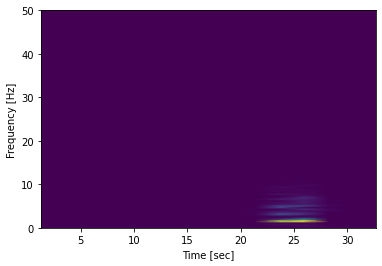

In [582]:
f, t, Sxx = spectrogram(acceleration.aX, fs=100)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [889]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 100.0       # sample rate, Hz
cutoff = 5.0  # desired cutoff frequency of the filter, Hz

acceleration.aX = butter_lowpass_filter(acceleration.aX, cutoff, fs)
acceleration.aY = butter_lowpass_filter(acceleration.aY, cutoff, fs)
acceleration.aZ = butter_lowpass_filter(acceleration.aZ, cutoff, fs)

<AxesSubplot:xlabel='time', ylabel='aZ'>

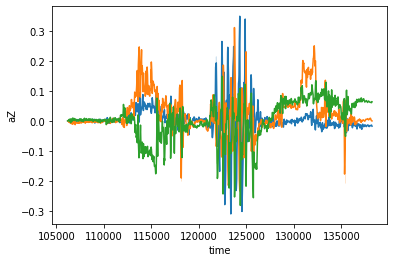

In [890]:
_a = acceleration.iloc[::graph_samplerate]
sns.lineplot(data=_a, x="time", y="aX")
sns.lineplot(data=_a, x="time", y="aY")
sns.lineplot(data=_a, x="time", y="aZ")

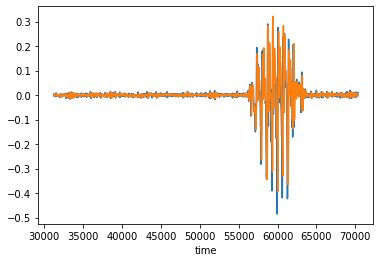

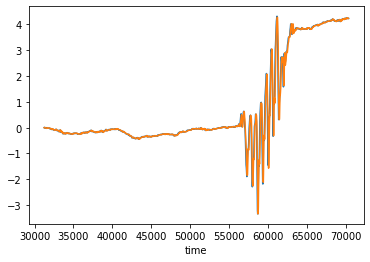

In [551]:
a, b = int(0 * rps), int(100 * rps)
sns.lineplot(acceleration.time.iloc[a:b], vertical_acceleration[a:b])
sns.lineplot(acceleration.time.iloc[a:b], vertical_filtered[a:b])
plt.show()
velsample_orig = sp.integrate.cumtrapz(y=vertical_acceleration[a:b])
velsample = sp.integrate.cumtrapz(y=vertical_filtered[a:b])
sns.lineplot(acceleration.time.iloc[a+1:b], velsample_orig)
sns.lineplot(acceleration.time.iloc[a+1:b], velsample)
plt.show()

<AxesSubplot:xlabel='time', ylabel='gZ'>

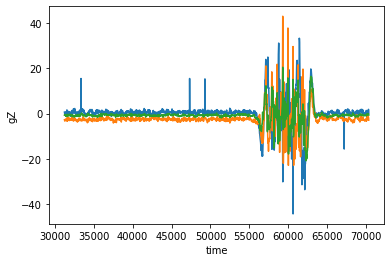

In [552]:
sns.lineplot(data=df, x="time", y="gX")
sns.lineplot(data=df, x="time", y="gY")
sns.lineplot(data=df, x="time", y="gZ")

In [553]:
gyro = df.loc[:,["time", "gX", "gY", "gZ"]].copy()

<AxesSubplot:xlabel='time', ylabel='gZ'>

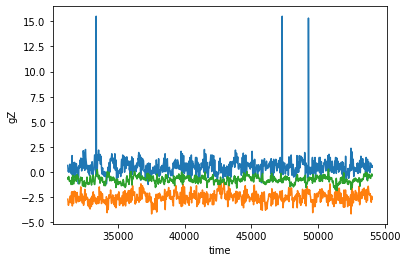

In [555]:
_df = gyro.iloc[:20*rps]
# _df.loc[:,["aX"]] = sp.ndimage.median_filter(_df.loc[:,["aX"]], 5)
# _df.loc[:,["aY"]] = sp.ndimage.median_filter(_df.loc[:,["aY"]], 5)
# _df.loc[:,["aZ"]] = sp.ndimage.median_filter(_df.loc[:,["aZ"]], 5)
# _df = df.iloc[30:90]
_dfsample = _df.iloc[::graph_samplerate]
sns.lineplot(data=_dfsample, x="time", y="gX")
sns.lineplot(data=_dfsample, x="time", y="gY")
sns.lineplot(data=_dfsample, x="time", y="gZ")

In [556]:
zero_gyro = _df.loc[:,["gX", "gY", "gZ"]].mean(axis=0)
gyro.loc[:,["gX", "gY", "gZ"]] = gyro.loc[:,["gX", "gY", "gZ"]] - zero_gyro

<AxesSubplot:xlabel='time', ylabel='gZ'>

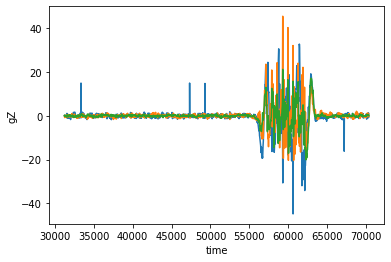

In [557]:
sns.lineplot(data=gyro, x="time", y="gX")
sns.lineplot(data=gyro, x="time", y="gY")
sns.lineplot(data=gyro, x="time", y="gZ")

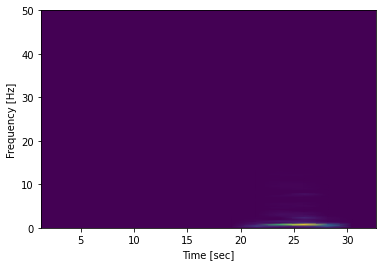

In [558]:
f, t, Sxx = spectrogram(gyro.gX, fs=100)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [559]:
cutoff = 2.0
gyro.gX = butter_lowpass_filter(gyro.gX, cutoff, fs)
gyro.gY = butter_lowpass_filter(gyro.gY, cutoff, fs)
gyro.gZ = butter_lowpass_filter(gyro.gZ, cutoff, fs)

<AxesSubplot:xlabel='time', ylabel='gZ'>

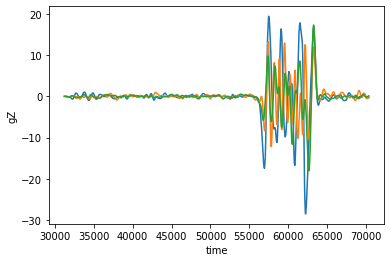

In [560]:
sns.lineplot(data=gyro, x="time", y="gX")
sns.lineplot(data=gyro, x="time", y="gY")
sns.lineplot(data=gyro, x="time", y="gZ")

In [561]:
gyro.loc[1:, ["thetaX", "thetaY", "thetaZ"]] = pd.DataFrame(sp.integrate.cumtrapz(y=gyro.loc[:, ["gX", "gY", "gZ"]], x=gyro.time/1000, axis=0), columns=["thetaX", "thetaY", "thetaZ"])

<AxesSubplot:xlabel='time', ylabel='thetaZ'>

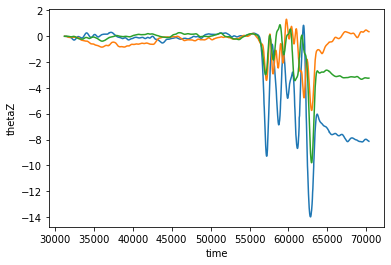

In [562]:
sns.lineplot(data=gyro, x="time", y="thetaX")
sns.lineplot(data=gyro, x="time", y="thetaY")
sns.lineplot(data=gyro, x="time", y="thetaZ")

In [563]:
def get_rotation(angles):
    return sp.spatial.transform.Rotation.from_euler("xyz",angles.values,degrees=True)

ground_vectors = gyro.iloc[1:-1].loc[:, ["thetaX", "thetaY", "thetaZ"]].apply(lambda x: pd.Series(get_rotation(x).apply(ground_vector), index=["aX", "aY", "aZ"]), axis=1)

<AxesSubplot:xlabel='time', ylabel='aZ'>

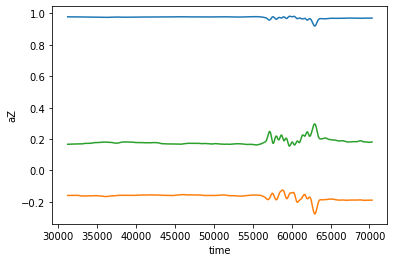

In [564]:
sns.lineplot(data=ground_vectors, x=acceleration.time.iloc[1:-1], y="aX")
sns.lineplot(data=ground_vectors, x=acceleration.time.iloc[1:-1], y="aY")
sns.lineplot(data=ground_vectors, x=acceleration.time.iloc[1:-1], y="aZ")

In [565]:
acceleration = df.iloc[1:-1].loc[:, ["aX", "aY", "aZ"]] - ground_vectors
acceleration["time"] = df.time.iloc[1:-1]

<AxesSubplot:xlabel='time', ylabel='aZ'>

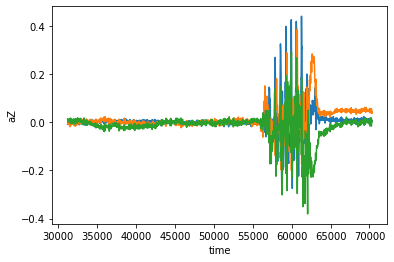

In [566]:
sns.lineplot(data=acceleration, x="time", y="aX")
sns.lineplot(data=acceleration, x="time", y="aY")
sns.lineplot(data=acceleration, x="time", y="aZ")